It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/CNN/cat_vs_dogs.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/cat_vs_dogs.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
tf.random.set_seed(0)

# Introduction to Tensorflow  Dataset
[Tensorflow tf.data.Dataset tutorial](https://www.tensorflow.org/guide/data)

TensorFlow's tf.data API, which provides a convenient way to create efficient input pipelines for training and evaluation of machine learning models. `tf.data.Dataset` is an abstraction of a
sequence of elements.

The first step to using the tf.data API is creating a Dataset object. Datasets can be created from various sources, including in-memory data, files, or by generating data on-the-fly.

For this example, let's create a dataset from an in-memory NumPy array.

In [2]:
# Create a sample NumPy array
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Create a tf.data Dataset from the NumPy array
dataset = tf.data.Dataset.from_tensor_slices(data)

The `Dataset` object is a Python iterable. This makes it possible to consume its
elements using a for loop:

In [3]:
for elem in dataset:
      print(elem.numpy())

1
2
3
4
5
6
7
8
9
10


Now that we have a dataset, we can apply various transformations to prepare the data for training. Some common transformations include shuffling, batching, and repeating.

**Shuffle**

Randomly shuffles the elements of this dataset.

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

In [4]:
buffer_size = 2

dataset = dataset.shuffle(buffer_size)

for elem in dataset:
      print(elem.numpy())

2
1
4
3
6
5
7
9
10
8


作用：在取数据前，维护一个大小为 buffer_size 的缓冲区，从中随机弹出一个元素，并把下一个新元素放进去，周而复始。

结果：顺序被随机化；buffer_size 越大，打乱越“彻底”。

buffer_size == 数据集大小 ⇒ 近似完美乱序。

buffer_size 很小（如 2） ⇒ 只能在局部窗口内交换，乱序有限，所以你看到的输出只是部分打乱（比如 2,1,4,3,…）。

小结：第 1 步把数组包装成可流水线处理的 Dataset；第 2 步用一个固定大小的随机缓冲区对其做打乱，buffer_size 控制随机程度与内存占用。

**Batch**

Combines consecutive elements of this dataset into batches.

In [ ]:
batch_size = 2

dataset = dataset.batch(batch_size)

for elem in dataset:
      print(elem.numpy())

含义：把连续的样本合并成一个小批（tensor 的第一维 = 批大小）。

作用：模型训练/推理时一次喂一批，GPU/CPU 利用率更高。

细节：

最后一个 batch 可能不足 batch_size（比如总数是奇数）。

需要固定大小时：dataset.batch(B, drop_remainder=True)。

想要充分打乱：通常 shuffle → batch（而不是先 batch）。

In addition to using in-memory data, the `tf.data` API can also read data from files, such as images or text files. For example, let's create a dataset of text lines from a sample file.

In [5]:
# Create a sample text file
with open("sample.txt", "w") as f:
    f.write("This is a sample text file.\n")
    f.write("Each line represents an element in the dataset.\n")
    f.write("We can apply various transformations to the data.\n")
    f.write("This makes it easy to prepare data for training.\n")

# Create a tf.data Dataset from the text file
dataset = tf.data.TextLineDataset("sample.txt")
for elem in dataset:
      print(elem.numpy())

b'This is a sample text file.'
b'Each line represents an element in the dataset.'
b'We can apply various transformations to the data.'
b'This makes it easy to prepare data for training.'


含义：按行读取文本文件，每一行就是数据集中的一个元素（dtype=string 的标量张量）。

适用：日志、CSV、JSONL、分词前的原始语料等。
（多文件可传列表：TextLineDataset([file1, file2, ...])）

To preprocess the text data, we can apply a map function to the dataset. This allows us to perform arbitrary operations on each element.

In [6]:
# Define a preprocessing function
def preprocess_text(line):
    line = tf.strings.lower(line)
    line = tf.strings.strip(line)
    return line

# Apply the preprocessing function to the dataset
dataset = dataset.map(preprocess_text)

for elem in dataset:
      print(elem.numpy())

b'this is a sample text file.'
b'each line represents an element in the dataset.'
b'we can apply various transformations to the data.'
b'this makes it easy to prepare data for training.'


用 map 做逐元素预处理

# Cat vs dog

In [7]:
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
dataset = dataset['train']
class_names = ['cat', 'dog']

size = tf.data.experimental.cardinality(dataset).numpy()
print(f'number of images:{size}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.HSVX96_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
number of images:23262


We need all images to be the same size, we can use [`resize`](https://www.tensorflow.org/api_docs/python/tf/image/resize):

```python
tf.image.resize(
    images, size, method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
```


In [8]:
image_size = (96, 96, 3)


def preprocess_img(images, size=(96, 96)):
    return tf.image.resize(images, size)

dataset = dataset.map(lambda images, labels: (preprocess_img(images), labels))

dataset.map(...) 的作用是：把你写的函数应用到数据集的每一个元素，返回“同样是一个 Dataset，但元素已经被按你的函数变换过”。

Split the dataset, you can use [different techniques](https://www.tensorflow.org/datasets/splits)

In [9]:
batch_size = 32
train_size = int(0.75 * size)
val_size = int(0.1 * size)

train_ds = dataset.take(train_size)
train_ds = train_ds.shuffle(1000).batch(batch_size).cache()
remaining = dataset.skip(train_size)

val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

val_ds = val_ds.shuffle(1000).batch(batch_size).cache()
test_ds = test_ds.batch(batch_size).cache()

这段代码在做三件事：切分数据集 → 打乱/分批/缓存 → 预取加速。

逐行说明

train_size = int(0.75 * size) / val_size = int(0.1 * size)
计算训练/验证的样本数（size 是整个 dataset 的样本总数）。

train_ds = dataset.take(train_size)
取前 train_size 个样本作为训练集。
remaining = dataset.skip(train_size) 把其余样本留作验证+测试的候选。

val_ds = remaining.take(val_size) / test_ds = remaining.skip(val_size)
在剩余部分里，再切一块做验证集；剩下就是测试集。

train_ds = train_ds.shuffle(1000).batch(batch_size).cache()
训练集：打乱 → 分批 → 缓存。

shuffle(1000) 用 1000 大小的缓冲区随机化顺序；

batch(batch_size) 组成小批；

cache() 把第一次遍历后的数据留在内存（或磁盘）里，加速后续 epoch。

val_ds = val_ds.shuffle(1000).batch(batch_size).cache()
验证集：这里也打乱 + 分批 + 缓存（验证集其实不必打乱，顺序无所谓）。

test_ds = test_ds.batch(batch_size).cache()
测试集：只分批 + 缓存（不打乱）。

train_ds = train_ds.prefetch(AUTOTUNE) / val_ds = val_ds.prefetch(AUTOTUNE)
预取：在训练/评估当前 batch 的同时，后台准备下一个批次，提升吞吐。

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

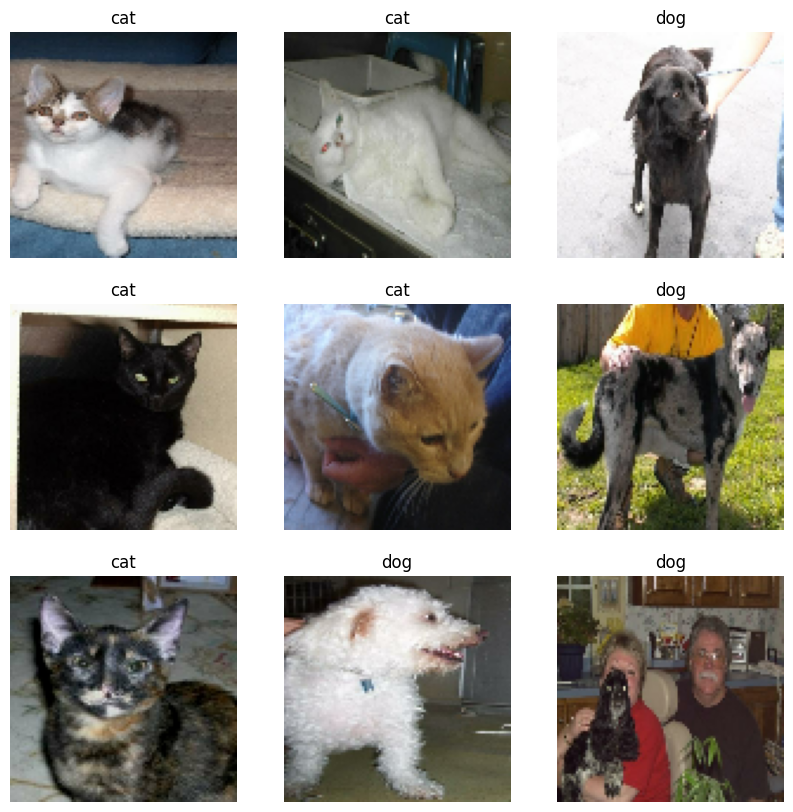

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# CNN model

You can visit the tutorial [Introduction_to_CNN](https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/Introduction_to_CNN.ipynb)

## CNN model in Keras



<img src="https://i.ibb.co/D8CmT6K/cnn.jpg" alt="cnn" border="0">



A Convolutional Neural Network (CNN) architecture has four main parts:

- A **convolutional layer** that extracts features from a source image.

- A **pooling layer** that reduces the image dimensionality without losing important features or patterns.

- A **flattening layer** that transforms a n-dimensional tensor into a vector that can be fed into a fully connected neural network.

- A **fully connected layer** also known as the dense layer.

### Rescaling

For converting the images to   \[0,1\] range.
```python
normalization_layer = layers.Rescaling(1./255)
next_layer = normalization_layer(prev_layer)
```
or simply
```python
reescaling = layers.Rescaling(1. / 255)(inputs)
```

### Convolutional layer

In the convolutional layers (`Conv2D`) we will configure the following parameters:

- **filters**: number of feature maps.
- **kernel_size**: can be either an integer or a tuple of two integers. Specifies the height and width of the kernel.
- **padding**: allows you to include padding in the input data. With 'valid' it is not applied, with 'same' it is configured so that the dimension at the output of the convolution is the same as at the input.
- **activation**: activation function implemented. Recommended ReLU.

[Link to documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    activation=None, kernel_regularizer=None)

```

With Functional API:
```python
next_layer = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_1')(prev_layer)
```

With Sequential:
```python
model.add(layers.Conv2D(filters=8,kernel_size=3, activation='relu', name='conv_1'))
```

### Pooling layer

A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity ( ReLU) you can choose between [average pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) or [max pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). Usually max pooling is the best choice.


With Functional API:
```python
conv_1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_1')(prev_layer)

pool_1 = layers.MaxPool2D(pool_size=(2, 2), name='pool_1')(conv_1)
```

With Sequential:
```python
model.add(layers.AveragePooling2D(pool_size=(2, 2), name='pool_1'))
```

### Flattening

Prepares a vector for the fully connected layers.

With Functional API:

```python
next_layer = layers.Flatten(name='flatten')(prev_layer)
```

With Sequential:
```python
model.add(layers.Flatten(name='flatten'))
```

There is another alternative for flattening that is a type of pooling that is called global pooling. Global pooling down-samples the entire feature map to a single value.

You can also choose between [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and [GlobalMaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

```python
model.add(layers.GlobalMaxPool2D(name='GlobalMaxPooling2D'))
```

### Fully-connected layer

Dense layer like a simple neural network

## Question 1: Create a model with two convolutional layers without pooling and without any regularization

In [12]:

inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(16, 3, padding='valid', activation='relu',
                       name='conv_1')(reescaling)

# Conv Layer 2
conv_2 = layers.Conv2D(16, 3, padding='valid', activation='relu',
                       name='conv_2')(conv_1)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(conv_2)
dense = layers.Dense(64, activation='relu', name='dense')(flat)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [13]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [14]:
epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=es_callback
)

Epoch 1/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.5847 - loss: 0.8468 - val_accuracy: 0.6952 - val_loss: 0.5658
Epoch 2/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7601 - loss: 0.4989 - val_accuracy: 0.7347 - val_loss: 0.5594
Epoch 3/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8616 - loss: 0.3185 - val_accuracy: 0.7081 - val_loss: 0.7352
Epoch 4/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9435 - loss: 0.1523 - val_accuracy: 0.7089 - val_loss: 1.0672
Epoch 4: early stopping


In [15]:
results = model_1.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.6930 - loss: 1.1245
Test Loss: 1.1199108362197876
Test Accuracy: 0.6948423981666565


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


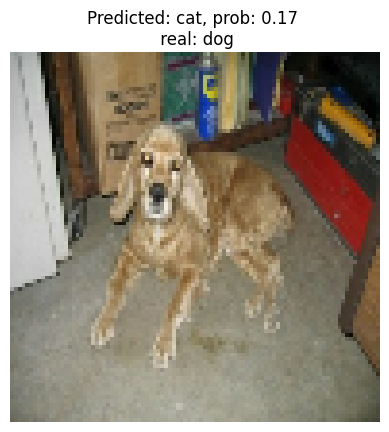

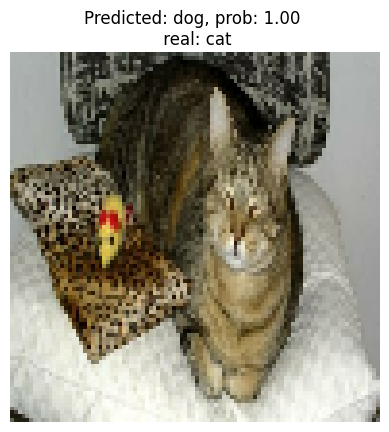

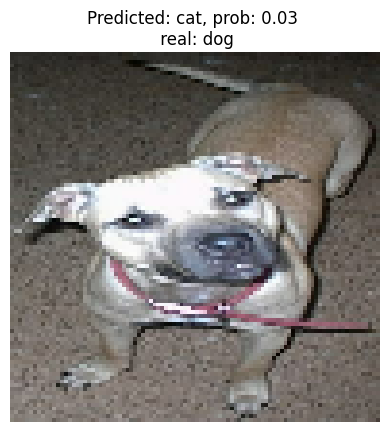

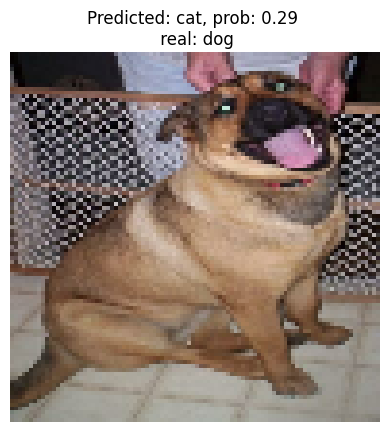

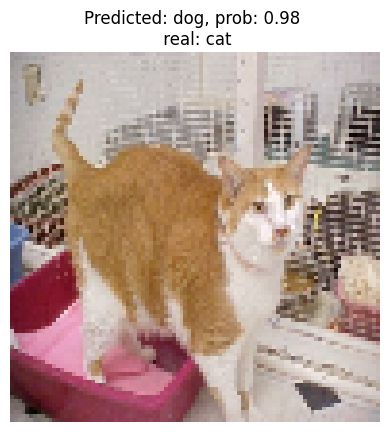

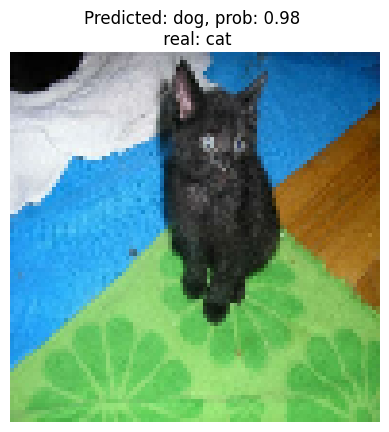

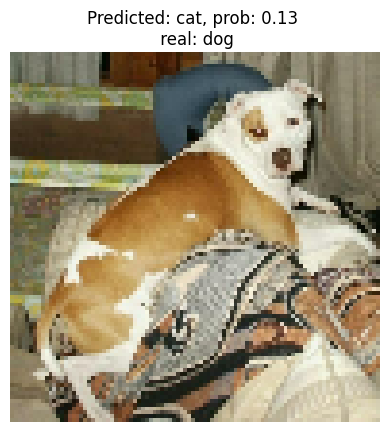

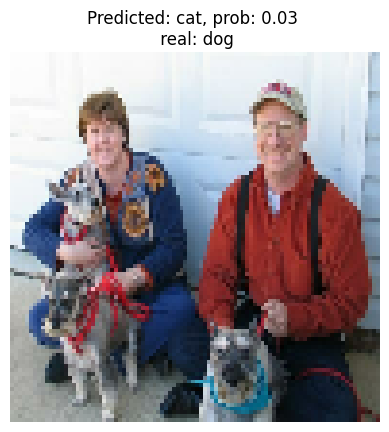

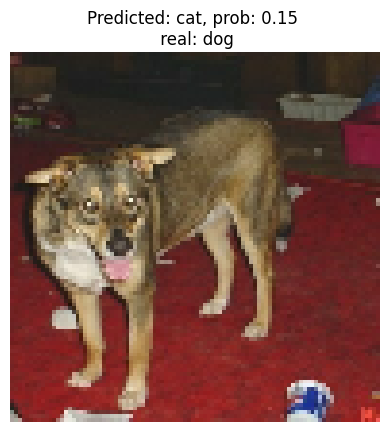

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


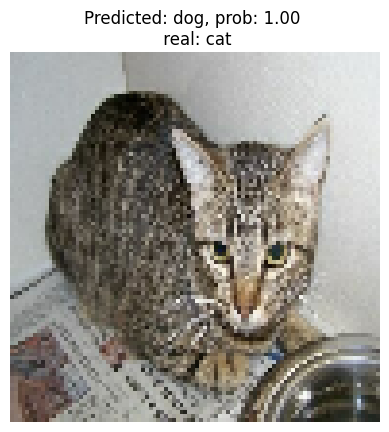

In [16]:
def show_errors(val_ds, model, class_names, n_images=10):
    n_plots = 0
    for images, labels in val_ds:
        pred_prob = model.predict(images)
        preds = (1.0 * (pred_prob >= 0.5)).astype(np.int32).flatten()
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in list(bad_pred_inds):
            n_plots += 1
            real_class = class_names[labels[ind].numpy()]
            pred_class = class_names[preds[ind]]
            prob = pred_prob[ind][0]
            plt.imshow(images[ind].numpy().astype("uint8"))
            plt.title('Predicted: {0}, prob: {1:.2f} \n real: {2}'.format(
                pred_class, prob, real_class))
            plt.axis('off')
            plt.show()

            if n_plots == n_images:
                return
    return


show_errors(test_ds, model_1, class_names, n_images=10)

## Question 2: Introduce pooling to the previous model and obtain a better `test_accuracy`, Do not use any regularization

In [17]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(16, 3, padding='valid', activation='relu',
                       name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(16, 3, padding='valid', activation='relu',
                       name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(pool_2)
dense = layers.Dense(64, activation='relu', name='dense')(flat)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [18]:
model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5567 - loss: 0.6832 - val_accuracy: 0.6956 - val_loss: 0.5615
Epoch 2/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7386 - loss: 0.5287 - val_accuracy: 0.7408 - val_loss: 0.5142
Epoch 3/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7720 - loss: 0.4719 - val_accuracy: 0.7575 - val_loss: 0.5062
Epoch 4/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7926 - loss: 0.4338 - val_accuracy: 0.7687 - val_loss: 0.4826
Epoch 5/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8125 - loss: 0.4048 - val_accuracy: 0.7743 - val_loss: 0.4912
Epoch 6/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8291 - loss: 0.3789 - val_accuracy: 0.7863 - val_loss: 0.4706
Epoch 7/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8458 - loss: 0.3510 - val_accuracy: 0.7923 - val_loss: 0.4757
Epoch 8/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8621 - loss: 0.3238 - val_accuracy: 0.7855 - 

In [19]:
results = model_2.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7807 - loss: 0.4982
Test Loss: 0.48267120122909546
Test Accuracy: 0.7845272421836853


In [ ]:
show_errors(test_ds, model_2, class_names, n_images=10)

## Question 3: Introduce regularization (you can try data augmentation) and increase the number of layers to obtain a better `test_accuracy`. Try to obtain `Test Accuracy > 0.82`



In [24]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip(),
    layers.RandomRotation(0.25),
  ]
)

In [25]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(32, 3, padding='valid', name='conv_1')(reescaling)
#32 → filters=32：这一层会学习 32 个卷积核，输出 32 张特征图（通道数变为 32）。3 → kernel_size=3：每个卷积核大小 3×3。padding='valid'：不填充（不在四周补 0）。结果是空间尺寸会变小
conv_1 = layers.BatchNormalization()(conv_1)
conv_1 = layers.Activation('relu')(conv_1)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(32, 3, padding='valid', name='conv_2')(pool_1)
conv_2 = layers.BatchNormalization()(conv_2)
conv_2 = layers.Activation('relu')(conv_2)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)

# Conv Layer 3
conv_3 = layers.Conv2D(32, 3, padding='valid', name='conv_3')(pool_2)
conv_3 = layers.BatchNormalization()(conv_3)
conv_3 = layers.Activation('relu')(conv_3)
pool_3 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_3')(conv_3)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(pool_3)
flat = layers.Dropout(0.3)(flat)
dense = layers.Dense(64, activation='relu', name='dense')(flat)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [26]:
model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.6395 - loss: 0.6511 - val_accuracy: 0.6277 - val_loss: 0.6782
Epoch 2/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7705 - loss: 0.4831 - val_accuracy: 0.6277 - val_loss: 0.7312
Epoch 3/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7997 - loss: 0.4282 - val_accuracy: 0.7231 - val_loss: 0.5492
Epoch 4/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8215 - loss: 0.3936 - val_accuracy: 0.6608 - val_loss: 0.6529
Epoch 5/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8385 - loss: 0.3640 - val_accuracy: 0.6556 - val_loss: 0.7158
Epoch 6/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8454 - loss: 0.3511 - val_accuracy: 0.6844 - val_loss: 0.6539
Epoch 7/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8554 - loss: 0.3269 - val_accuracy: 0.8250 - val_loss: 0.3863
Epoch 8/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8684 - loss: 0.3054 - val_accuracy: 0

In [23]:
results = model_3.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8505 - loss: 0.3630
Test Loss: 0.3649606704711914
Test Accuracy: 0.8472779393196106


In [ ]:
show_errors(test_ds, model_3, class_names, n_images=10)

## Question 3.1 (Optional): Tune a CNN Architecture with Keras Tuner

[Keras Tuner tutorial](https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/Regression_tuner.ipynb) :

Hyperparameters are of two types:
1. **Model hyperparameters** like number of units, type of activation or number hidden layers.
2. **Algorithm hyperparameters** like the learning rate in adam.

The model-building function takes an argument `hp` from which you can sample hyper-parameters.

```python
def build_model(hp):
    ...
    return model

```

- `hp.Int` to sample an integer from a certain range:
```python
hp.Int('units', min_value=32, max_value=256, step=32, default=64)
```
- `hp.Float` to sample a float number from a certain range:
```python
hp.Float('dropout', min_value=0.0, max_value=0.1, default=0.005, step=0.05)
```
- `hp.Choice` to select values in a list:
```python
hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
```
- [list of hyperparameter methods](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/)

Keras Tuner：把可调超参数（网络结构 & 训练算法）用 hp 定义出来，然后自动搜索出更好的组合。

超参数两类

模型超参数：卷积层数、每层 filters 数、kernel_size、激活函数、dropout 等。

算法超参数：学习率、优化器等。

build_model(hp) 的用法

Keras Tuner会向你的构建函数传入 hp，你用它来“抽样”超参数：

hp.Int(name, min_value, max_value, step, default)：采整数

hp.Float(name, min_value, max_value, step/ sampling='log', default)：采浮点

hp.Choice(name, values)：在备选项里选一个

hp.Boolean(name)：选 True/False

In [27]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


In [28]:
import kerastuner as kt

/tmp/ipython-input-1654478174.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


给 Keras Tuner 用的“可调 CNN 模型工厂”。它返回一个二分类的 CNN，并把若干结构/正则化超参数交给 hp 搜索

HP = HyperParameters（超参数）。就是你在训练前需要手动设定、不能由训练自己学出的参数，比如：卷积块数量、filters 个数、kernel_size、dropout 比例、Dense 单元数、学习率/优化器等。在 Keras Tuner 里用 hp.Int / hp.Float / hp.Choice 等把它们声明出来，调参器就会在这些取值里搜索更好的组合。

整体逻辑：输入→归一化→(可调数量的 卷积+Dropout+池化)×N→Flatten→Dense(+Dropout)→Sigmoid，配好损失与优化器，交给 Keras Tuner 自动探索这些超参数的最优组合。

In [29]:
def build_cnn_model(hp):
    """Build a CNN model with tunable architecture and dropout regularization using Functional API."""
    inputs = keras.Input(shape=image_size)

    # Start the model flow with the inputs
    x = layers.Rescaling(1. / 255)(inputs)

    # Tune the number of convolutional blocks (try 1-3 blocks)
    for i in range(hp.Int('num_conv_blocks', min_value=1, max_value=3)):
        # Tune the number of filters in each Conv2D layer
        x = layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same'
        )(x)

        # Add dropout after the Conv2D layer
        x = layers.Dropout(
            hp.Float(f'conv_dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        )(x)

        # Add pooling layer
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten layer before dense layers
    x = layers.Flatten()(x)

    x = layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    )(x)

    x = layers.Dropout(
        hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)
    )(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [30]:
tuner = kt.RandomSearch(build_cnn_model,
                     objective='val_loss',
                     max_trials=2,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Start the search
tuner.search(
    train_ds,  # Use your TensorFlow dataset
    validation_data=val_ds,
    epochs=10,
    callbacks=[es_callback]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 2 Complete [00h 00m 51s]
val_loss: 0.524042010307312

Best val_loss So Far: 0.524042010307312
Total elapsed time: 00h 01m 37s


In [31]:
# Print the optimal architecture
print(f"Best number of convolutional blocks: {best_hps.get('num_conv_blocks')}")
for i in range(best_hps.get('num_conv_blocks')):
    print(f"Conv block {i+1}:")
    print(f"  - Filters: {best_hps.get(f'filters_{i}')}")
    print(f"  - Kernel size: {best_hps.get(f'kernel_size_{i}')}")
    print(f"  - Dropout rate: {best_hps.get(f'conv_dropout_{i}')}")

print(f"Dense layer units: {best_hps.get('dense_units')}")
print(f"Dense layer dropout: {best_hps.get('dense_dropout')}")

Best number of convolutional blocks: 1
Conv block 1:
  - Filters: 48
  - Kernel size: 3
  - Dropout rate: 0.4
Dense layer units: 128
Dense layer dropout: 0.1


In [32]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96, 96, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 110592)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,155,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,157,377 (54.01 MB)

 Trainable params: 14,157,377 (54.01 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:

# Train the model
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[es_callback]
)

# Evaluate on test dataset
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5344 - loss: 1.3721 - val_accuracy: 0.6574 - val_loss: 0.6204
Epoch 2/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6639 - loss: 0.6041 - val_accuracy: 0.7059 - val_loss: 0.5629
Epoch 3/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7273 - loss: 0.5167 - val_accuracy: 0.7369 - val_loss: 0.5318
Epoch 4/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7593 - loss: 0.4605 - val_accuracy: 0.7373 - val_loss: 0.5249
Epoch 5/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7855 - loss: 0.4050 - val_accuracy: 0.7377 - val_loss: 0.5362
Epoch 6/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8036 - loss: 0.3679 - val_accuracy: 0.7352 - val_loss: 0.5423
Epoch 7/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8293 - loss: 0.3225 - val_accuracy: 0.7369 - val_loss: 0.5667
Epoch 8/25
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8410 - loss: 0.2960 - val_acc

## Question 4: Try transfer learning

In [34]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size,
                                                     include_top=False)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [36]:
inputs = tf.keras.Input(shape=image_size, name='input')

# pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)

# classifier
flat = tf.keras.layers.Flatten()(x)
flat = tf.keras.layers.Dropout(0.5)(flat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flat)

model_tl = tf.keras.Model(inputs, outputs)
model_tl.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │        11,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,505 (8.66 MB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 2

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/2
546/546 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.9344 - loss: 0.1958 - val_accuracy: 0.9600 - val_loss: 0.1377
Epoch 2/2
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9616 - loss: 0.1437 - val_accuracy: 0.9596 - val_loss: 0.1669


In [38]:
results = model_tl.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9594 - loss: 0.1590
Test Loss: 0.17261627316474915
Test Accuracy: 0.9601719379425049


In [39]:
show_errors(test_ds, model_tl, class_names, n_images=10)

KeyboardInterrupt: 

# Generalization

“Generalization（泛化）”做了啥？
目的是：用互联网上的一张全新图片（模型没见过）测试你训练好的多个模型，看看它们在未见过的数据上的表现——这就是“泛化能力”。

In [40]:
def read_image(image_path, target_size=None):
    image = tf.keras.preprocessing.image.load_img(image_path,
                target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype(np.uint8)
    return image

def predict_plot(image_path, model, class_names, image_size):
    image = read_image(image_path, image_size[:2])
    prob = model.predict(np.expand_dims(image, 0))[0][0]
    pred_class = class_names[(1.0 * (prob >= 0.5)).astype(np.int32)]
    plt.imshow(image)
    plt.title(
        'Predicted: {0}, prob: {1:.2f}'
        .format(pred_class, prob))
    plt.axis('off')
    plt.show()

读取并按 target_size 缩放，转成数组；此处只做了 resize，没有归一化（注意你的模型若在训练时做了 Rescaling(1/255) 或专用 preprocess_input，预测时要保持一致）。



image_size[:2]：只取高宽用于 resize。

np.expand_dims(image, 0)：加 batch 维 → (1, H, W, 3)，才能喂 model.predict。

prob = ...[0][0]：二分类 sigmoid 输出是形如 [[p]] 的数组，取出标量概率。

pred_class = class_names[int(prob >= 0.5)]：用 0.5 阈值把概率变成类别索引（0/1）并映射到类名。

然后用 plt.imshow 展示图片，并在标题里打印 Predicted: 类别, prob: 概率。

In [ ]:
url = 'https://assets.sainsburys-groceries.co.uk/gol/6754229/1/640x640.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_1.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

In [ ]:
url = 'https://i.ytimg.com/vi/3dcli9i_pvA/hqdefault.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_2.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

In [ ]:
url = 'https://thumbs.dreamstime.com/b/halloween-ghost-portrait-funny-dog-black-background-adorable-pup-muzle-153863580.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_3.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)